In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import math

# AIRFLOW
from datetime import datetime, timedelta

from airflow import DAG
from airflow.operators.bash import BashOperator
from airflow.operators.python_operator import PythonOperator


In [7]:
# DEFAULT ARGS
default_args = {
    'owner': 'airflow',
    'depends_on_past': False,
    'start_date': datetime(2019, 1, 1),
}

# THE DAG
dag = DAG(
    dag_id='milestone3_dag',
    default_args=default_args,
    description='Milestone3 dag',
    schedule_interval='@once',
    catchup=False,
)

# 1-Extract

In [15]:
def reading():
    print('STARTED PIPELINE, READ DATA')

In [16]:
def read_data(athlete_df_path ,regoins_df_path,medals_df_path):
    athlete_df = pd.read_csv(athlete_df_path)
    regoins_df = pd.read_csv(regoins_df_path)
    medals_df = pd.read_excel(medals_df_path)
    return athlete_df ,regoins_df ,medals_df


# 3 - load

In [8]:
def save_df(df,Path): 
    df.to_csv(Path, index = False)
def saving():
    print('ENDED PIPELINE, SAVED DATA')


# 2-a Data Cleaning

In [13]:
def IQR_technique(column,df): # Helper method
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    cut_off = IQR * 1.5
    lower = Q1 - cut_off
    upper =  Q3 + cut_off
    return lower ,upper

In [14]:
def data_cleaning(): #in This function, We detect isolate, outliers and impute the missing values ... 
    athlete_df ,regoins_df ,medals_df = read_data('datasets/athlete_events.csv' ,'datasets/noc_regions.csv',
                                                  'datasets/Medals.xlsx')
    regoins_df.drop('notes' ,axis = 1, inplace= True)
    clean_df = athlete_df.copy()
    cat_col= clean_df[['Sex','Season' , 'Medal' ]]
    encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
    coded_col= pd.DataFrame(encoder.fit_transform(cat_col))
    coded_col.index = athlete_df.index
    coded_col.columns = encoder.get_feature_names_out(cat_col.columns)
    clean_df = pd.concat([clean_df.drop(cat_col.columns, axis=1), coded_col], axis=1)
    clean_df = clean_df.rename(columns={'Medal_nan': 'No_Medal'})
    clean_df['Age'] = clean_df['Age'].fillna(clean_df['Sport'].map(clean_df.groupby('Sport')['Age'].median()))
    # Weight imputation 
    data = clean_df.dropna(subset = ['Weight', 'Height'] ,axis =  0 )
    X = data[['Age','Sex_M','Height']]
    y = data['Weight']
    W_reg = LinearRegression().fit(X.values, y.values)
    height_mean = clean_df['Height'].median()
    for i, row in clean_df.iterrows():
        if math.isnan(row['Weight']):
            x=[row['Age'] , row['Sex_M'] ]
            if  math.isnan(row['Height']):
                x = x+[height_mean]
            else:
                x = x+[row['Height']]

            predicted = W_reg.predict([x])
            clean_df.at[i,'Weight'] = predicted
            
    data = clean_df.dropna(subset = ['Height'] ,axis =  0 )
    X = data[['Age','Sex_M','Weight']]
    y = data['Height']
    W_reg = LinearRegression().fit(X.values, y.values)
    for i, row in clean_df.iterrows():
        if math.isnan(row['Height']):
            x=[row['Age'] , row['Sex_M'] ,row['Weight'] ]
            predicted = W_reg.predict([x])
            clean_df.at[i,'Height'] = predicted
            
    clean_WoOutliers_df= clean_df.copy()
    
    lower ,upper =IQR_technique('Age',clean_WoOutliers_df)
    qurey1= clean_WoOutliers_df[clean_WoOutliers_df['Age']< lower]
    qurey1 =qurey1[ qurey1['No_Medal'] == 1]
    clean_WoOutliers_df.drop(qurey1.index, inplace=True)
    Age_outliers = pd.concat([clean_WoOutliers_df[clean_WoOutliers_df['Age']> upper], clean_WoOutliers_df[clean_WoOutliers_df['Age']< lower] ],axis=0)
    clean_WoOutliers_df = clean_WoOutliers_df[clean_WoOutliers_df['Age']< upper]
    clean_WoOutliers_df = clean_WoOutliers_df[clean_WoOutliers_df['Age']> lower]
    lower ,upper =IQR_technique('Weight',clean_WoOutliers_df)
    query2 = clean_WoOutliers_df[clean_WoOutliers_df['Weight']< lower ]
    query2 = query2 [query2['Height']> 170]
    clean_WoOutliers_df.drop(query2.index, inplace=True)
    Weight_outliers = pd.concat([clean_WoOutliers_df[clean_WoOutliers_df['Weight']> upper], clean_WoOutliers_df[clean_WoOutliers_df['Weight']< lower] ],axis=0)
    clean_WoOutliers_df = clean_WoOutliers_df[clean_WoOutliers_df['Weight']< upper]
    clean_WoOutliers_df = clean_WoOutliers_df[clean_WoOutliers_df['Weight']> lower]
    lower ,upper =IQR_technique('Height',clean_WoOutliers_df)
    Height_outliers = pd.concat([clean_WoOutliers_df[clean_WoOutliers_df['Height']> upper], clean_WoOutliers_df[clean_WoOutliers_df['Height']< lower] ],axis=0)
    outliers = pd.concat([Age_outliers , Weight_outliers,Height_outliers ],axis=0)
    clean_WoOutliers_df = clean_WoOutliers_df[clean_WoOutliers_df['Height']< upper]
    clean_WoOutliers_df = clean_WoOutliers_df[clean_WoOutliers_df['Height']> lower]
    save_df(clean_WoOutliers_df,'datasets/results/athletes_without_outliers.csv')
    save_df(outliers,'datasets/results/athletes_outliers.csv')
    print('DATA READING AND CLEANING SUCCESS')


# 2-b Data Integration

In [11]:
def unify(df):   # Helper method to unify country names on all dataset, pre-implemeted in MS2 
    df.replace('USA', "United States of America", inplace = True)
    df.replace('Tanzania', "United Republic of Tanzania", inplace = True)
    df.replace('Democratic Republic of Congo', "Democratic Republic of the Congo", inplace = True)
    df.replace('Congo', "Republic of the Congo", inplace = True)
    df.replace('Lao', "Laos", inplace = True)
    df.replace('Syrian Arab Republic', "Syria", inplace = True)
    df.replace('Serbia', "Republic of Serbia", inplace = True)
    df.replace('Czechia', "Czech Republic", inplace = True)
    df.replace('UAE', "United Arab Emirates", inplace = True)
    df.replace('UK', "United Kingdom", inplace = True)
    df.replace('United States', "United States of America", inplace = True)
    df.replace('Czech Republic (Czechia)', "Czech Republic", inplace = True)
    df.replace('DR Congo', "Democratic Republic of the Congo", inplace = True)
    df.replace('Serbia', "Republic of Serbia", inplace = True)
    df.replace('Tanzania', "United Republic of Tanzania", inplace = True)
    df.replace('Great Britain', "United Kingdom", inplace = True)
    df.replace("People's Republic of China", "China", inplace = True)
    df.replace("ROC", "Russia", inplace = True)
    

In [6]:
def Aggregate_df(df):  # Helper method to Aggregate athletes dataset, pre-implemeted in MS2
    df['Gold']=0
    df['Silver']=0
    df['Bronze']=0
    df['Total']=0
    
    y_t_clean =df.groupby(['Year','Team'])
    g=y_t_clean['Medal_Gold'].sum().to_dict()
    s=y_t_clean['Medal_Silver'].sum().to_dict()
    b=y_t_clean['Medal_Bronze'].sum().to_dict()
    
    golds=[]
    slivers = [] 
    bronzes =[]
    for i, row in df.iterrows():
        golds.append(g[( row['Year'] ,row['Team'] )] )
        slivers.append(s[( row['Year'] ,row['Team'] )] )
        bronzes.append(b[( row['Year'] ,row['Team'] )] )

    df['Gold'] = golds
    df['Silver'] = slivers
    df['Bronze'] = bronzes
    df['Total'] = df['Gold']+df['Silver']+df['Bronze']
    return df

In [12]:
def data_integration(): #in This function, we integrate the aggregated athletes df and medals_df ...
    Athletes_clean = pd.read_csv('datasets/results/athletes_without_outliers.csv')
    outliers = pd.read_csv('datasets/results/athletes_outliers.csv')
    medals_df = pd.read_excel('datasets/Medals.xlsx')
    regoins_df = pd.read_csv('datasets/noc_regions.csv')
    
    mergerd_Clean_df = pd.merge(Athletes_clean, regoins_df, on='NOC', how='left')
    mergerd_outliers_df = pd.merge(outliers, regoins_df, on='NOC', how='left')
    unify(mergerd_Clean_df)
    unify(mergerd_outliers_df)

    unify(medals_df)
    df_org =  pd.concat([mergerd_Clean_df,mergerd_outliers_df],axis=0)
    df_org['region'] = df_org['region'].fillna(df_org['NOC'].map(df_org.groupby('NOC')['region'].agg(pd.Series.mode)))
    aggregated_df = Aggregate_df(df_org)

    medals_df['Year'] =2021
    medals_df.columns = ['Rank','Team','Gold','Silver','Bronze','Total','Rank by Total','Year']
    medals_df = medals_df[['Team','Gold','Silver','Bronze','Total','Year' ]]
    appended_df = aggregated_df.append(medals_df)
    
    save_df(appended_df,'datasets/results/aggregated_athletes_medals.csv')
    save_df(df_org,'datasets/results/full_clean_athletes.csv')
    save_df(mergerd_Clean_df,'datasets/results/without_outliers_athletes_regions.csv')
    save_df(mergerd_outliers_df,'datasets/results/outliers_athletes_regions.csv')
    print('DATA INTEGRATION SUCCESS')
    



# 2-c Feature Engineering

In [8]:
def calculate_BMI(df):  # Helper method to  get BMI category of the athlete
    BMI =[]
    for i, row in df.iterrows():
        HinM=row['Height']/100
        bmi= row['Weight']/(HinM*HinM)
        if bmi<18.5:
            BMI.append('Underweight')
        elif bmi<25:
            BMI.append('Normal')
        elif bmi<30:   
            BMI.append('Overweight')
        else:
            BMI.append('Obese')
    
    df['BMI Group'] = BMI

In [9]:
def calculate_AgeGroup(df):  # Helper method to  get Age group of the athlete
    age_group =[]
    for i, row in df.iterrows():
        age=row['Age']
        if(age<20):
            age_group.append('Too Young')
        elif(age<30):
            age_group.append('Youth')
        elif(age<50):
            age_group.append('Middle Age')
        elif(age<100):
            age_group.append('Old Adult')

    df['Age Group'] = age_group


In [13]:
def feature_engineering(): #in This function, we engineer 2 new featurs BMI and Age groups for each Athles ...
    df =pd.read_csv('datasets/results/full_clean_athletes.csv')
    calculate_BMI(df)
    calculate_AgeGroup(df)
    
    save_df(df,'datasets/results/full_clean_athletes_feature_engineered.csv')
    print('FEATURE ENGINEERING SUCCESS')


# Air flow Pipeline

In [ ]:
# THE TASKS
data_read_clean = PythonOperator(
    task_id='cleaning_data',
    python_callable=data_cleaning,
    dag=dag,
)


data_integration = PythonOperator(
    task_id='data_integration',
    python_callable=data_integration,
    dag=dag,
)


data_feature_engineering = PythonOperator(
    task_id='feature_engineering',
    python_callable=feature_engineering,
    dag=dag,
)


reading_task = PythonOperator(
    task_id='reading_data',
    python_callable=reading,
    dag=dag,
)


saving_task = PythonOperator(
    task_id='saving_data',
    python_callable=saving,
    dag=dag,
)

# DEPENDENCIES
reading_task >> data_read_clean >> data_integration >> data_feature_engineering >> saving_task



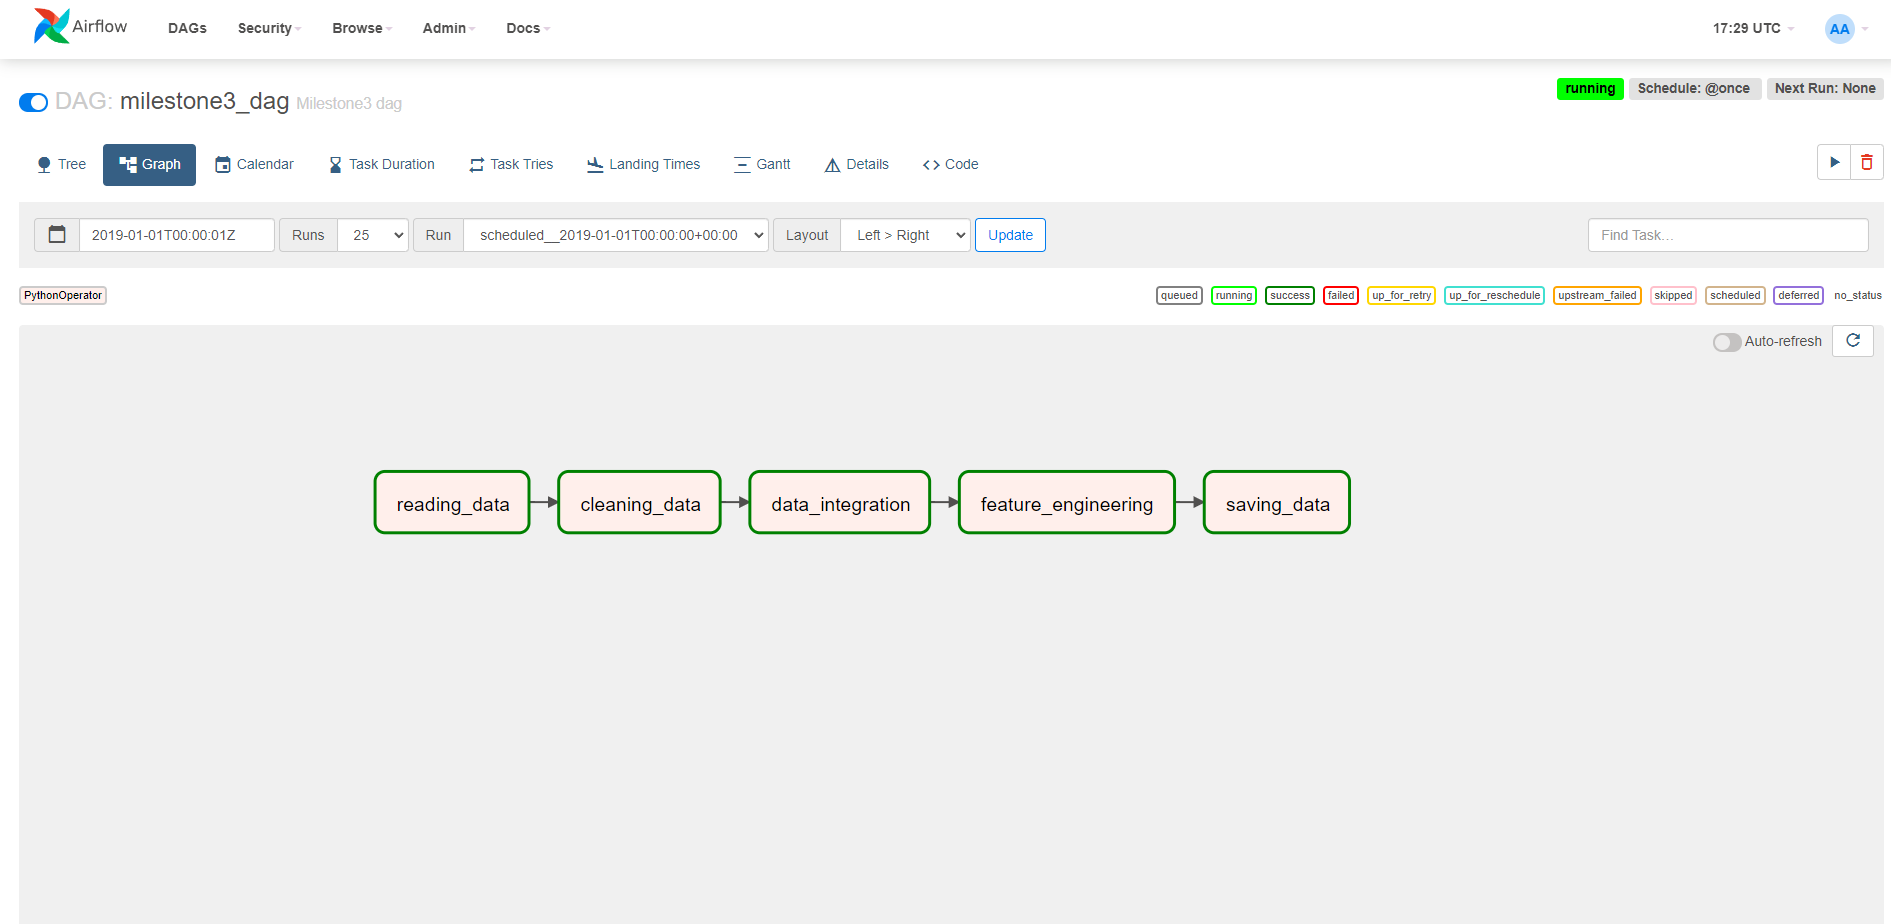

In [20]:
from IPython import display
display.Image('AiflowPipeline.png')